# Import Libraries

In [3]:
#!pip install sas7bdat

In [29]:
from sas7bdat import SAS7BDAT
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.mstats import zscore
import statsmodels.api as sm
from scipy.stats import norm

# Import Data

In [5]:
# Import data
with SAS7BDAT('insurance.sas7bdat') as file:
    df_sas = file.to_data_frame()

In [10]:
# Display dataframe
display(df_sas.head())

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


In [8]:
# Inspect data
display(df_sas.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null float64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null float64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(4), object(3)
memory usage: 73.3+ KB


None

In [7]:
print(f'There is {df_sas.shape[0]} rows and {df_sas.shape[1]} in our dataframe')

There is 1338 rows and 7 in our dataframe


# Data Cleaning

In [11]:
# We recode the variable 'sex'

# Create a dictionary that maps strings to integers
mapping = {'female':1, 'male':0}

# Convert the 'sex' strings to integers using the 'mapping'
df_sas['new_sex'] = df_sas.sex.map(mapping)

# Print the unique values in 'new_sex'
display(df_sas.new_sex.unique())

array([1, 0])

In [16]:
# We recode the variable 'smoker'
mapping = {'yes':1, 'no':0}
df_sas['new_smoker'] = df_sas.smoker.map(mapping)

In [17]:
# We recode the variable 'children' by grouping modalities 4 and 5
mapping = {0:0, 1:1, 2:2, 3:3, 4:4, 5:4}
df_sas['new_children'] = df_sas.children.map(mapping)

In [18]:
# We recode the variable 'region'
mapping = {'northeast':1, 'northwest':2, 'southeast':3, 'southwest':4}
df_sas['new_region'] = df_sas.region.map(mapping)

In [19]:
# We delete the old variables
df_sas.drop(['sex', 'children', 'smoker', 'region'], axis=1, inplace=True)

In [20]:
# We rename the new variables 
df_sas.rename(columns={'new_sex':'sex', 'new_smoker':'smoker', 'new_children':'children', 'new_region':'region'}, inplace=True)

In [21]:
# We recode the variable 'region' into 3 indicator variables for the Variation Inflation Factor (VIF) after 

# region1 
mapping = {1:1}
df_sas['region1'] = df_sas.region.map(mapping)
df_sas.region1.fillna(0, inplace=True)

# region2
mapping = {2:1}
df_sas['region2'] = df_sas.region.map(mapping)
df_sas.region2.fillna(0, inplace=True)

# region3
mapping = {3:1}
df_sas['region3'] = df_sas.region.map(mapping)
df_sas.region3.fillna(0, inplace=True)

# region 4 is the reference category

In [22]:
# We apply categorical types for the appropriate variables 
df_sas.sex = df_sas.sex.astype('category', inplace=True)

for col in ['smoker', 'region', 'region1', 'region2', 'region3']:
    df_sas[col] = df_sas[col].astype('category', inplace=True)

# Summary Statistics

In [23]:
# Summary statistics of numerical variables
display(df_sas.describe())

,age,bmi,charges,children
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265,1.081465
std,14.049960,6.098187,12110.011237,1.166768
min,18.000000,15.960000,1121.873900,0.000000
25%,27.000000,26.296250,4740.287150,0.000000
50%,39.000000,30.400000,9382.033000,1.000000
75%,51.000000,34.693750,16639.912515,2.000000
max,64.000000,53.130000,63770.428010,4.000000


In [24]:
# Summary statitics of categorical variables
display(df_sas.describe(include='category'))

,sex,smoker,region,region1,region2,region3
count,1338,1338,1338,1338.0,1338.0,1338.0
unique,2,2,4,2.0,2.0,2.0
top,0,0,3,0.0,0.0,0.0
freq,676,1064,364,1014.0,1013.0,974.0


In [27]:
# We verify if our data contains missing values 
for col in df_sas.columns:
    print(f'{col} has {df_sas[col].isnull().sum()} missing values')

age has 0 missing values
bmi has 0 missing values
charges has 0 missing values
sex has 0 missing values
smoker has 0 missing values
children has 0 missing values
region has 0 missing values
region1 has 0 missing values
region2 has 0 missing values
region3 has 0 missing values


In [42]:
# Let's see how are independent variables are correlated (multicolinearity)
display(df_sas.corr()) 

,age,bmi,charges,children
age,1.000000,0.109272,0.299008,0.046832
bmi,0.109272,1.000000,0.198341,0.015185
charges,0.299008,0.198341,1.000000,0.074528
children,0.046832,0.015185,0.074528,1.000000


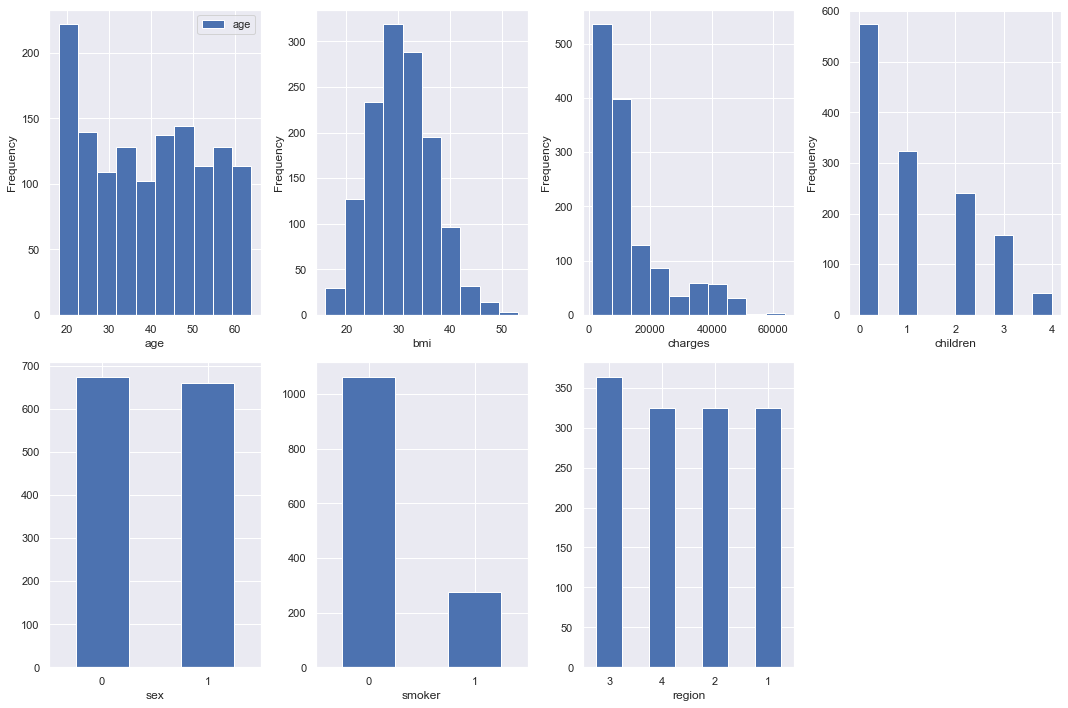

In [43]:
# We plot histograms of our independent continuous variables and bar plots of our independent categorical variables
sns.set()
plt.figure(figsize=(15,10))

plt.subplot(2,4,1)
df_sas.age.plot(kind='hist')
plt.legend()
plt.xlabel('age', rotation=0) 

plt.subplot(2,4,2)
df_sas.bmi.plot(kind='hist')
plt.xlabel('bmi')

plt.subplot(2,4,3)
df_sas.charges.plot(kind='hist')
plt.xlabel('charges')

plt.subplot(2,4,4)
df_sas.children.plot(kind='hist')
plt.xlabel('children')

plt.subplot(2,4,5)
df_sas.sex.value_counts().plot(kind='bar')
plt.xlabel('sex')
plt.xticks(rotation=0)

plt.subplot(2,4,6)
df_sas.smoker.value_counts().plot(kind='bar')
plt.xlabel('smoker')
plt.xticks(rotation=0)

plt.subplot(2,4,7)
df_sas.region.value_counts().plot(kind='bar')
plt.xlabel('region')
plt.xticks(rotation=0) # Pour les ticks sur l'axe des abscisses

plt.tight_layout()
plt.show()

# Treatement of our dependent variable 

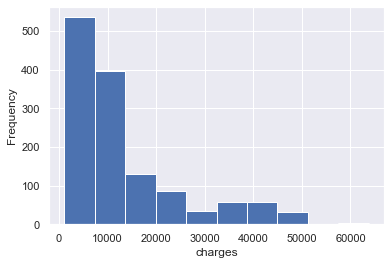

In [44]:
# We show that our dependent variable is "skewed" to the right
df_sas.charges.plot(kind='hist')
plt.xlabel('charges')
plt.show()

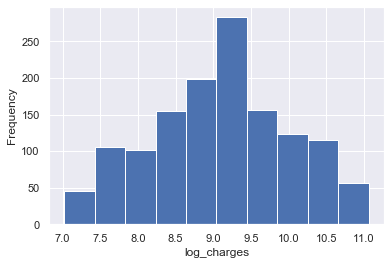

In [45]:
# We take the log of our dependent variable because it's "skewed" to the right
df_sas['log_charges'] = np.log(df_sas.charges)

# Histogram of log_charges to check normality
df_sas.log_charges.plot(kind='hist')
plt.xlabel('log_charges')
plt.show()

# Data Visualization

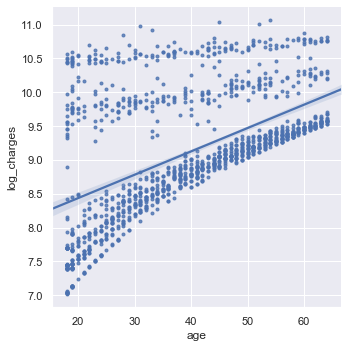

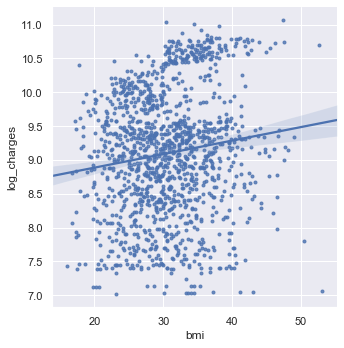

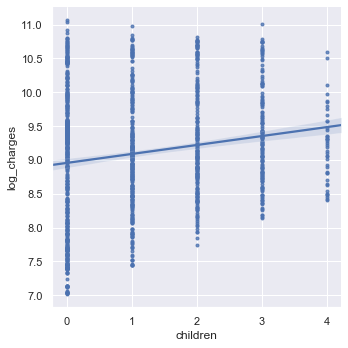

In [46]:
# We plot clouds points to visualize the relationship between Y and continuous variables
sns.lmplot(x='age', y='log_charges', data=df_sas, markers='.')
sns.lmplot(x='bmi', y='log_charges', data=df_sas, markers='.')
sns.lmplot(x='children', y='log_charges', data=df_sas, markers='.')

plt.show()

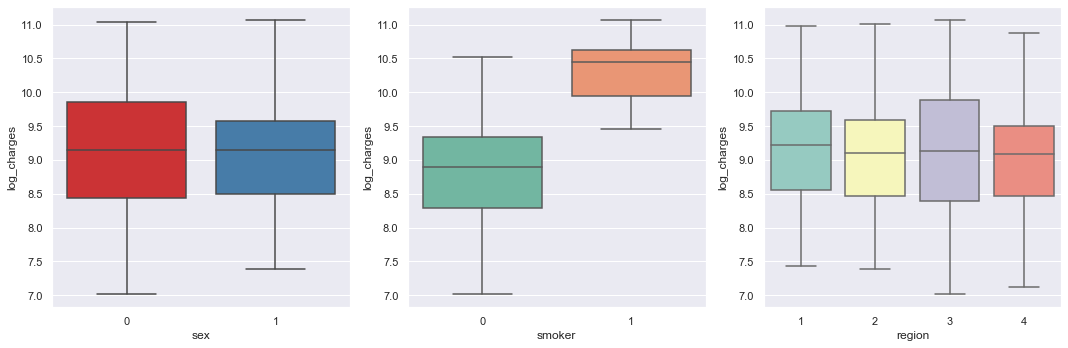

In [47]:
# We plot boxplots to visualize the relationship between Y and continuous variable
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(x='sex', y='log_charges', data=df_sas, palette='Set1')

plt.subplot(1,3,2)
sns.boxplot(x='smoker', y='log_charges', data=df_sas, palette='Set2')

plt.subplot(1,3,3)
sns.boxplot(x='region', y='log_charges', data=df_sas, palette='Set3')

plt.tight_layout()
plt.show()

# Simple Linear regression

In [48]:
# We insert the variables one by one in the model 
results = smf.ols('log_charges ~ bmi',data=df_sas).fit()
print(results.summary())

results = smf.ols('log_charges ~ C(region, Treatment(4))',data=df_sas).fit()
print(results.summary())

results = smf.ols('log_charges ~ age',data=df_sas).fit()
print(results.summary())

results = smf.ols('log_charges ~ smoker',data=df_sas).fit()
print(results.summary())

results = smf.ols('log_charges ~ children',data=df_sas).fit()
print(results.summary())

results = smf.ols('log_charges ~ sex',data=df_sas).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     23.94
Date:                Wed, 30 Oct 2019   Prob (F-statistic):           1.12e-06
Time:                        16:11:10   Log-Likelihood:                -1773.9
No. Observations:                1338   AIC:                             3552.
Df Residuals:                    1336   BIC:                             3562.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4852      0.128     66.378      0.0

# Multiple linear regression

In [49]:
# We adjust a multiple regression model by including all variables
results = smf.ols('log_charges ~ sex + smoker + age + C(region, Treatment(4)) + bmi + children', data=df_sas).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     550.3
Date:                Wed, 30 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:11:50   Log-Likelihood:                -808.00
No. Observations:                1338   AIC:                             1634.
Df Residuals:                    1329   BIC:                             1681.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [50]:
# We determine the VIF to check the multicolinearity in our independent variables
variables = results.model.exog
vif = pd.DataFrame()
vif['Features'] = results.params.index
vif['VIF Factor'] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
print(vif.iloc[1:]) # On exclut la constante 

                       Features  VIF Factor
1                      sex[T.1]    1.008868
2                   smoker[T.1]    1.012198
3  C(region, Treatment(4))[T.1]    1.525923
4  C(region, Treatment(4))[T.2]    1.524885
5  C(region, Treatment(4))[T.3]    1.597034
6                           age    1.017179
7                           bmi    1.106738
8                      children    1.004753


In [51]:
# We determine standardized coefficients

# Transform endog and exog variables with zscore
df_sas_z = df_sas
df_sas_z.apply(zscore)
results_z = smf.ols('log_charges ~ sex + smoker + age + C(region, Treatment(4)) + bmi + children', data=df_sas_z).fit()
print(results_z.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     550.3
Date:                Wed, 30 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:12:38   Log-Likelihood:                -808.00
No. Observations:                1338   AIC:                             1634.
Df Residuals:                    1329   BIC:                             1681.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

# Conditions of model's validity

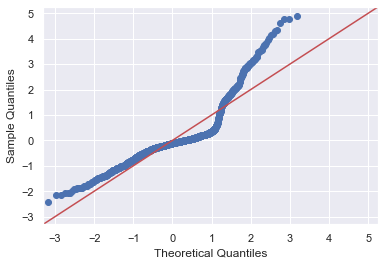

In [52]:
# We check the normality of the residuals by plotting qqplot
res = results.resid
fig = sm.qqplot(res, fit=True, line='45')
plt.show()

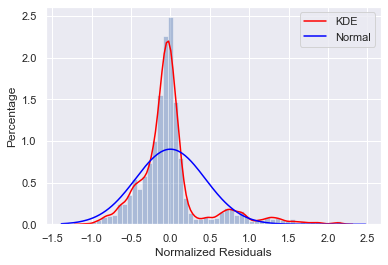

In [53]:
# We check the normality of the residuals by plotting an histogram
sns.distplot(res, fit=norm, fit_kws={'color':'blue', 'label':'Normal'}, kde=True,kde_kws={'color':'red', 'label':'KDE'})
plt.xlabel('Normalized Residuals')
plt.ylabel('Percentage')
plt.legend()
plt.show()

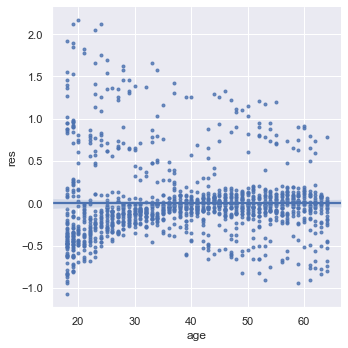

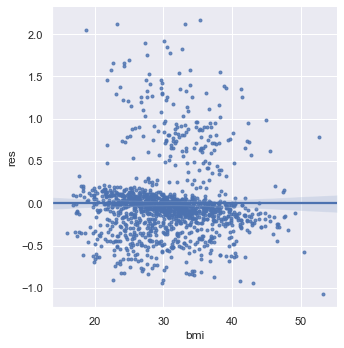

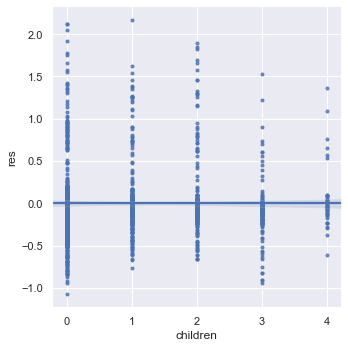

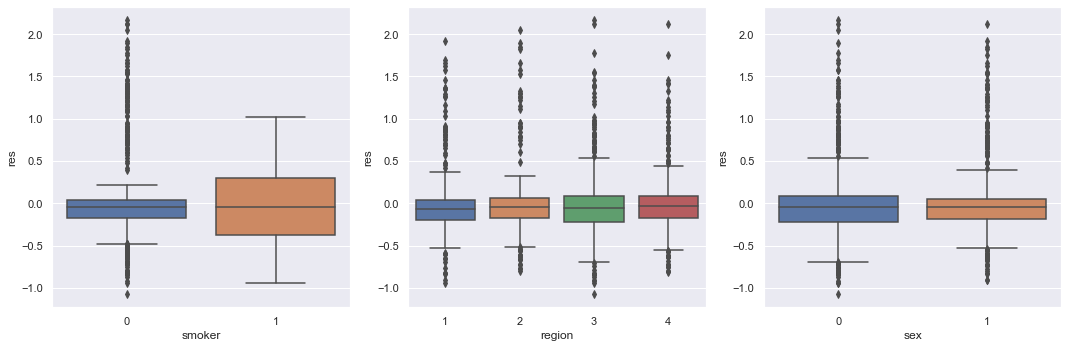

In [56]:
# We check the conditions wich states that the errors have an average of 0 and that variance is constant
df_sas['res'] = res # We add residuals to df_sas
sns.lmplot(x='age', y='res', data=df_sas, markers='.')
sns.lmplot(x='bmi', y='res', data=df_sas, markers='.')
sns.lmplot(x='children', y='res', data=df_sas, markers='.')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(x='smoker', y='res', data=df_sas)

plt.subplot(1,3,2)
sns.boxplot(x='region', y='res', data=df_sas)

plt.subplot(1,3,3)
sns.boxplot(x='sex', y='res', data=df_sas)

plt.tight_layout()
plt.show()

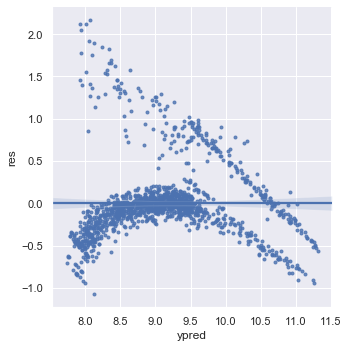

In [57]:
# ypred in terms of res
df_sas['ypred'] = results.predict()
sns.lmplot(x='ypred', y='res', data=df_sas, markers='.')
plt.show()

# Interaction terms

In [58]:
# We add the interactions terms bmi*smoker, age*smoker*bmi et age*smoker
results_z = smf.ols('log_charges ~ sex + smoker + age + C(region, Treatment(4)) + bmi + children + bmi*smoker + age:smoker:bmi + age*smoker', data=df_sas_z).fit()
print(results_z.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     520.9
Date:                Wed, 30 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:16:09   Log-Likelihood:                -619.39
No. Observations:                1338   AIC:                             1265.
Df Residuals:                    1325   BIC:                             1332.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       